<a href="https://colab.research.google.com/github/NILodio/EACD-MONOGRAFIA/blob/master/01_MONOGRAFIA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Packages

In [1]:
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
import os
import uuid
import json
import tensorflow as tf

# Loading the Data
We have to write a load_data function that load the images and the labels from the folder.

In [2]:
from local.lib import load_data as dt
dic = {'Formato_1': 1, 'Formato_2': 2, 'Formato_3': 3}

In [3]:
Data = dt.create_and_read_metadata(images_path=  'local/data/imgs' ,medata_path= 'local/data',split_value= 0.7 , labels_dic=dic)

In [4]:
Train , Test = (Data[Data['split'] == 'train'] , Data[Data['split'] != 'train'] )

# Let's explore the dataset

1. How many training and testing examples do we have ?
2. What is the size of the images ?
3. What is the proportion of each observed category ?

In [5]:
n_train = Train.shape[0]
n_test = Test.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))


Number of training examples: 261
Number of testing examples: 134


<AxesSubplot:>

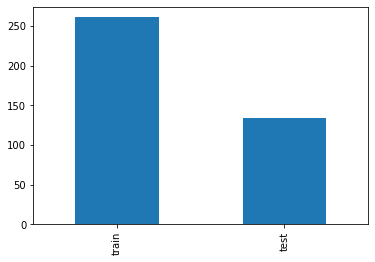

In [6]:
Data['split'].value_counts().plot(kind='bar')

In [7]:
Train.head(5)

,names,xmin,xmax,ymin,ymax,split,label
0,09-22-2020-14.53.24(1).jpg,0.137416,0.279979,0.394874,0.420505,train,1
1,09-22-2020-14.53.24(10).jpg,0.153446,0.291938,0.391390,0.415141,train,1
2,09-22-2020-14.53.24(100).jpg,0.142093,0.296076,0.380736,0.406633,train,1
4,09-22-2020-14.53.24(102).jpg,0.137374,0.289899,0.372496,0.402928,train,1
6,09-22-2020-14.53.24(104).jpg,0.128908,0.293472,0.375156,0.408504,train,1


### Let's explore the dataset with label == 1


In [8]:
Train[Train['label'] == 1].describe()

,xmin,xmax,ymin,ymax,label
count,136.000000,136.000000,136.000000,136.000000,136.0
mean,0.139390,0.287146,0.386539,0.413561,1.0
std,0.055271,0.055381,0.024567,0.024105,0.0
min,0.000688,0.120358,0.276580,0.301790,1.0
25%,0.133376,0.278218,0.379508,0.405804,1.0
50%,0.139593,0.286585,0.385909,0.413408,1.0
75%,0.147026,0.295635,0.393429,0.420696,1.0
max,0.708696,0.863478,0.594419,0.618430,1.0


<AxesSubplot:>

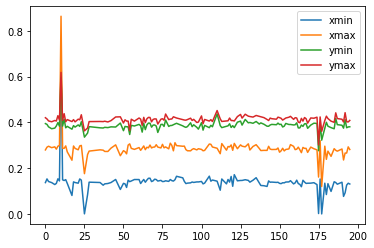

In [9]:
Train[['xmin','xmax','ymin','ymax']][Train['label'] == 1].plot()

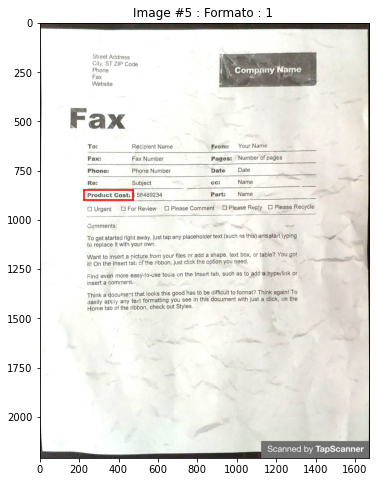

In [10]:
from local.lib import F_Plots as MyPlot
import importlib 
importlib.reload(MyPlot) 
MyPlot.display_random_image(Train,1,True)

# Split Data

In [11]:
from local.lib import tf_DataSet as My_tf

train_sources = My_tf.build_sources_from_metadata(Data[Data['label'] == 1])
test_sources = My_tf.build_sources_from_metadata(Data[Data['label'] == 1], mode='test')


# Tensorflow DataSet

In [12]:
tf_dataset = My_tf.make_tf_dataset(train_sources, training=False,
    batch_size=3, num_epochs=1,
    num_parallel_calls=3)

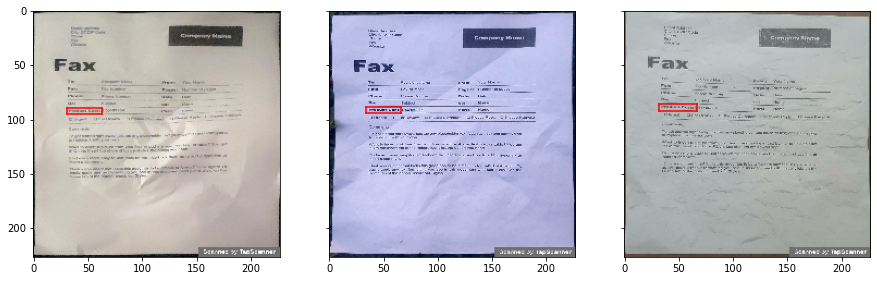

In [13]:
dataset = iter(tf_dataset)
MyPlot.imshow_batch_of_three(next(dataset))

## Modelo # 1

In [14]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters=6, kernel_size=(5, 5), activation='tanh', input_shape=(227,227,3)))
model.add(tf.keras.layers.AveragePooling2D())

model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5), activation='tanh'))
model.add(tf.keras.layers.AveragePooling2D())

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(units=120, activation='tanh'))

model.add(tf.keras.layers.Dense(units=84, activation='tanh'))

model.add(tf.keras.layers.Dense(units=4, activation = 'sigmoid'))
model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.optimizers.Adam(0.0001))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 223, 223, 6)       456       
_________________________________________________________________
average_pooling2d (AveragePo (None, 111, 111, 6)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 107, 107, 16)      2416      
_________________________________________________________________
average_pooling2d_1 (Average (None, 53, 53, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 44944)             0         
_________________________________________________________________
dense (Dense)                (None, 120)               5393400   
_________________________________________________________________
dense_1 (Dense)              (None, 84)                1

In [15]:
Data_train = My_tf.make_tf_dataset(train_sources, training=True,
    batch_size=4, num_epochs=1,
    num_parallel_calls=2)

Data_test = My_tf.make_tf_dataset(test_sources, training=True,
    batch_size=1, num_epochs=1,
    num_parallel_calls=2)

In [16]:
print(model.evaluate(Data_train))

34/34 [==============================] - 2s 68ms/step - loss: 0.0600
0.06003999337553978


In [17]:
h = model.fit(x=Data_train, epochs=10,validation_data=Data_test, validation_steps=1)

Train for 34 steps, validate for 1 steps
Epoch 1/10
34/34 [==============================] - 1s 37ms/step - loss: 0.0212 - val_loss: 0.0160
Epoch 2/10
34/34 [==============================] - 1s 27ms/step - loss: 0.0089 - val_loss: 0.0045
Epoch 3/10
34/34 [==============================] - 1s 27ms/step - loss: 0.0064 - val_loss: 0.0045
Epoch 4/10
34/34 [==============================] - 1s 28ms/step - loss: 0.0064 - val_loss: 0.0057
Epoch 5/10
34/34 [==============================] - 1s 28ms/step - loss: 0.0063 - val_loss: 0.0040
Epoch 6/10
34/34 [==============================] - 1s 28ms/step - loss: 0.0062 - val_loss: 0.0070
Epoch 7/10
34/34 [==============================] - 1s 28ms/step - loss: 0.0060 - val_loss: 0.0054
Epoch 8/10
34/34 [==============================] - 1s 28ms/step - loss: 0.0057 - val_loss: 0.0057
Epoch 9/10
34/34 [==============================] - 1s 28ms/step - loss: 0.0047 - val_loss: 0.0028
Epoch 10/10
34/34 [==============================] - 1s 28ms/step - 

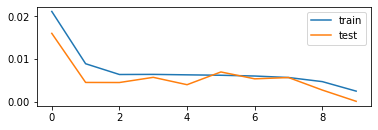

In [18]:
plt.subplot(2,1,1)
plt.plot(h.history['loss'],label='train')
plt.plot(h.history['val_loss'],label='test')
plt.legend()

In [19]:
predictions= model.predict(Data_test)
predictions_list=predictions.tolist()
imgs,b,a= zip(*test_sources)
sources= [r for r in zip(imgs,predictions_list,a)]


In [20]:
Example_Data = My_tf.make_tf_dataset(sources, training=False,
    batch_size=3, num_epochs=1,
    num_parallel_calls=3)

Data_plt = iter(Example_Data)

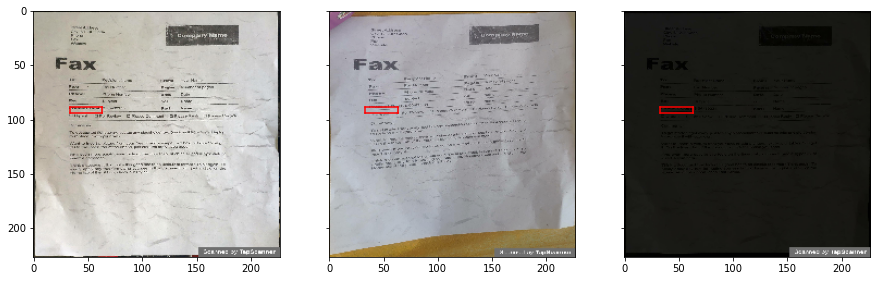

In [21]:
MyPlot.imshow_batch_of_three(next(Data_plt),show_box=True)

In [22]:
Prueba_Test_IoU =Test[Test['label'] == 1]
Prueba_Test_IoU = Prueba_Test_IoU[['xmin','xmax','ymin','ymax']].values

In [23]:
Prueba_Test_IoU.shape

(61, 4)

In [24]:
Prueba_Test_IoU[:10,:]

array([[0.13285024, 0.28309179, 0.38175047, 0.40968343],
       [0.15113974, 0.32309217, 0.37848325, 0.40141093],
       [0.14074074, 0.28490028, 0.3824667 , 0.41383756],
       [0.13747521, 0.29543952, 0.38445912, 0.40731336],
       [0.0909737 , 0.24449183, 0.37863071, 0.40352697],
       [0.12694611, 0.27065868, 0.38640429, 0.40921288],
       [0.13864943, 0.28735632, 0.38372093, 0.40919158],
       [0.13582343, 0.27956989, 0.38510368, 0.41515023],
       [0.14036885, 0.28842213, 0.37210201, 0.40030912],
       [0.07666667, 0.23388889, 0.3371875 , 0.3634375 ]])

In [25]:
predictions.shape

(61, 4)

# IoU

In [26]:
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    
    xA = max(boxA[1], boxB[1])
    yA = max(boxA[3], boxB[3])
    xB = min(boxA[0], boxB[0])
    yB = min(boxA[2], boxB[2])
    
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    
    # compute the area of both the prediction and ground-truth
    # rectangles
    
    boxAArea = (boxA[0] - boxA[1] + 1) * (boxA[2] - boxA[3] + 1)
    boxBArea = (boxB[0] - boxB[1] + 1) * (boxB[2] - boxB[3] + 1)
    
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    
    return iou

In [98]:
bb_intersection_over_union(Prueba_Test_IoU[0],predictions[0])

0.9774618976961015

## Examples 

In [105]:
from collections import namedtuple
import numpy as np


Prueba = Test[Test['label'] == 1]['names']
Detection = namedtuple("Detection", ["image_path", "gt", "pred"])

Examples = []

for i in range(len(Prueba)):
    Examples.append(Detection(os.path.join('local\data\imgs',Prueba.iloc[i]),Prueba_Test_IoU[i] , predictions[i]))


In [113]:
for i in Examples[0:5]:
    print(tuple(i.gt[:2]))

(0.13285024154589373, 0.28309178743961355)
(0.15113974231912786, 0.3230921704658077)
(0.14074074074074075, 0.2849002849002849)
(0.13747521480502314, 0.29543952412425645)
(0.09097370291400142, 0.24449182658137886)
